## A Differentiable Approximation for Entropies 

We have seen how we can calculate the total entropy and the conditional entropy with regards to the labels of a mini-batch of image samples with the help of simple statistics based on binned distributions. In order to use the entropy as a cost function within the concept of gradient-based optimization, we need a differentiable approximation of the entropy terms. That turns out to be an easy exercise. 

Remember the sigmoid function?
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Let's use it to create a more interesting kind of *filter* function:

$$ f(x) = \sigma(x - x_l) \cdot \sigma(x + x_r) $$

For example, for $x_l=5$ and $x_r=15$, that function looks like

In [5]:
import numpy as np
import matplotlib.pyplot as plt

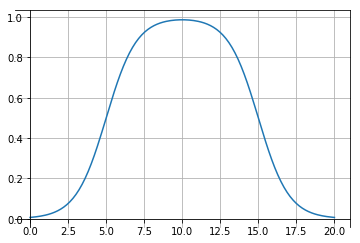

In [159]:
def f(x, x_l, x_r):
    return sigmoid(x - x_l) * sigmoid(-x + x_r)
x=np.linspace(0, 20, 200)
fig, ax = plt.subplots()
ax.plot(x, f(x, 5, 15))
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

See, what it does? It approximately maps all values in a certain bin's range to 1 and all values outside of it to 0. 

To make this function more square-looking and treat the borders appropriate, we introduce stretch and margin parameters. You'll easily figure out yourself what they do.

Here's the precise definition that we'll use in the following calucations

Let $ x_i \in [x_{min}, x_{max}] $ be a sample from distribution $D$, $d=x_{max}-x_{min}$,
let $\alpha, \epsilon$ be arbitrary real numbers representing a stretch and a margin, then we define the *bin filter* $\beta_n(x)$ for the $n$-th bin of width $d$ as

$$ \beta_n(x_i) = \sigma(\alpha \cdot (x_i - l_n) + \epsilon) \cdot 
 \sigma(\alpha \cdot ( -x_i + l_n + d + \epsilon))
$$

Here, $l_n$ is the left border of the $n$-th bin: $l_n = x_{min} + (n-1) \cdot d$ 

In [160]:
def beta(n, N, l, r, alpha, epsilon):
    """
    return the bin function for the n-th bin of N bins for numbers between l and r
    alpha and epsilon are stretch and margin parameters
    """
    d = (r - l) / N
    l_n = l + (n-1) * d
    def _beta(x):
        return sigmoid(alpha * (x-l_n+epsilon)) * sigmoid(alpha*(-x+l_n+d+epsilon))
    
    return _beta

This function has the nice property that it is differentiable and that it provides an excellent way to approximate a bin-distribution. Let's look at the following from an example distribution. Think of them as the values of a single activation for some small mini-batch. 

In [241]:
D=np.array([3,2,5,4,7,5,4,8,6,4,6,7,4,6,3,4,6,7,4,3,5,6,1,2,9,7,2,1,9,7,3,1])*10+5
L=np.array([0,0,1,1,1,0,1,2,0,1,0,2,0,1,0,1,1,1,0,0,1,1,0,0,2,2,0,0,2,1,0,0])
D

array([35, 25, 55, 45, 75, 55, 45, 85, 65, 45, 65, 75, 45, 65, 35, 45, 65,
       75, 45, 35, 55, 65, 15, 25, 95, 75, 25, 15, 95, 75, 35, 15])

Let's put them into 5 bins, like we did for the entropy statistics. Note that, of course, the choice of 5 is arbitrary, so consider this a hyper parameter. In fact, when you vary this parameter reasonably, this shouldn't have any noteworthy impact on the results. 

(array([ 6., 10.,  3., 10.,  3.]),
 array([15., 31., 47., 63., 79., 95.]),
 <a list of 5 Patch objects>)

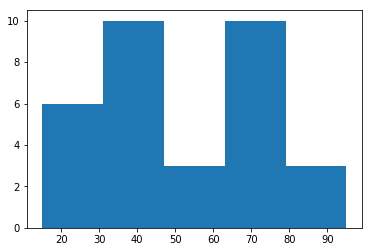

In [162]:
plt.hist(D, bins=5)

Now, we create the 5 functions $\beta_1(x_i)$ to $\beta_5(x_i)$ 

In [163]:
betas=[beta(n+1, 5, 15, 95, 5.0, 1) for n in range(5)]

And have a look at what e.g. $\beta_3(x_i)$ looks like. Don't get confused by the following code. The array index is zero-based. ```betas[2]``` is therefore the third *bin filter* function.

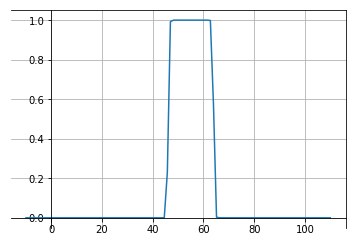

In [164]:
x=np.linspace(-10, 110, 100)
fig, ax = plt.subplots()
ax.plot(x, betas[2](x))
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

Now, let's use these functions to count the number of values $x_i$ that fall into a particular bin, and that in a differentiable manner! 

Let $c_k$ the number of values in bin $k$, $M$ be the number of samples. Think of $M$ as the size of a mini-batch. 

Now I claim that

$$ \sum_{i=1}^M \beta_k(x_i) \approx c_k$$

Don't believe me? Good. See for yourself:

In [142]:
sums=[np.sum(betas[n](D)) for n in range(5)]
sums

[5.979922670836051,
 9.999998164572752,
 3.0736213601671345,
 9.999998470433315,
 2.9866158276625643]

Compare that to the bin counts of the histogram above. Easy exercise. I promised. No magic. What's cool, is that we can now approximate the various entropies of the pixel or activation distributions within each mini-batch in a differentiable manner and do some experiments.

The Entropy of a distribution X was defined as

$$ H(X) := -\sum_{x \in \mathcal{X}} p(x) \log p(x)$$

Using the bin counts $c_k$ with $\sum c_k = M$ as shown above, we get

$$ H(X) = -\sum_{k=1}^N  \frac{c_k}{M} \log  \frac{c_k}{M}$$

and with our differentiable approximation

$$ H(X) = \log M -\frac{1}{M}\sum_{k=1}^N  \sum_{i=1}^M \beta_k(x_i)  \log  \sum_{i=1}^M \beta_k(x_i) $$



In [283]:
def entropy(D, N, alpha = 5.0, epsilon = 1.0):
    """
    Calculate the entropy of discrete sample D using N bins 
    """
    d_max=np.max(D)
    d_min=np.min(D)
    M = len(D)
    
    filter=[beta(n+1, N, d_max, d_min, alpha, epsilon) for n in range(N)]
    c=[np.sum(filter[k](D)) for k in range(N)] # this is summing over i
    sums = np.sum(c * np.log(c)) 
    return np.log(M) - sums / M

Note, that in the above implementation, we didn't supply lower and upper bounds so the counts may slightly differ from the previous calculations. In a scenario with a bigger range of values, that will not matter much. In the end, we know we're approximating the entropy anyway.

In [284]:
ent = entropy(D, 5)
ent

3.4657359027997265

Now, the conditional entropy goes just the same way, only that we need to mask the classes out before we count the bins. Remember what we learned in information theory?

$$ H(Y \big| X) = \sum_{x \in \mathcal{X}} \sum_{y\in \mathcal{Y}} p(x,y) \log(\frac{p(x,y)}{p(x)})$$

The implementation is pretty straight-forward

In [286]:
def cond_entropy(D, L, N_bins=5, alpha=5.0, epsilon=1.0):
    """
        calculate the conditional entropy of distribution D given class labels L
    """
    d_max=np.max(D)
    d_min=np.min(D)
    M=len(L)

    betas=[beta(n+1, N_bins, d_min, d_max, alpha, epsilon) for n in range(N_bins)]

    # mask[i] has 1 only for class i - 0 otherwise
    mask=[list(map(lambda x: int(x), L==k)) for k in range(3)]

    # three lists of counts = three conditional distributions
    cond_counts=[[np.sum(betas[n](D)*mask[k]) for n in range(5)] for k in range(3)]

    pxy=np.array(cond_counts) / M # p(x,y)

    px = np.sum(cond_counts, axis=1) / M # p(x)

    # need to transpose forth and back to enable broadcasting
    pxy_px=(pxy.T / px.T).T

    return -np.sum(pxy * np.log(pxy_px))


In [287]:
cond_entropy(D, L)

1.0426756965186548

Now we intend to train a network to minimize the conditional entropy while maintaining the given entropy of the signal.